In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import radians, cos, sin, asin, sqrt
pd.options.mode.chained_assignment = None


In [171]:
'''Load and save functions.'''

filepath = r'scripts/stalbert'

# load file
def load(fName): 
    f = filepath + "/" + "{}.txt".format(fName)
    return pd.read_csv(f)

# save file
def save(dfName,fName):
    df = dfName
    df.to_csv(filepath + '/' + "{}_NEW.txt".format(fName), sep =',', index=False, float_format="%.6f")
    return print("Saved {}_NEW.txt to {}".format(fName,filepath))

# haversine
def haversine(row):

    R = 3959.87433 # miles

    dLat = radians(row['stop_lat'] - row['shape_pt_lat'])
    dLon = radians(row['stop_lon'] - row['shape_pt_lon'])
    lat1 = radians(row['shape_pt_lat'])
    lat2 = radians(row['stop_lat'])

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

# load GTFS files
trips = load('trips')
stops = load('stops')
stop_times = load('stop_times')
shapes = load('shapes')
routes = load('routes')
# routes.info()

In [ ]:
trips = load('trips')
stops = load('stops')
stop_times = load('stop_times')
shapes = load('shapes')
routes = load('routes')

rte=3015
shp=24007
trp=787279

# def shapes2stops (rte,shp,trp):
singleRoute = trips.route_id == rte #3032
shapeList = trips.shape_id.unique().tolist()
# data = []

subShapes = shapes[shapes.shape_id == shp]
# subTripsList = trips[trips.shape_id == i].trip_id.unique().tolist()
# subTripsList = trips[singleRoute].trip_id.unique().tolist()
subTripsList = trips[trips.trip_id == trp].trip_id.tolist()
# subTrips = trips[trips.trip_id.isin(subTripsList)]
subStopTimesList = stop_times.stop_id[stop_times.trip_id.isin(subTripsList)].tolist()
subStops = stops[stops.stop_id.isin(subStopTimesList)]


# create a geodataframe to do an intersection 
intersect_df = gpd.GeoDataFrame(subShapes, geometry = gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
intersect_df['shape_pt_geometry'] = intersect_df['geometry']
intersect_df.drop(['geometry'],axis=1)

# stop dataframe with a buffer- distance can be adjusted if need be
stopdf = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
stopdf['geometry_point'] = stopdf.geometry
stopdf['geometry'] = stopdf.geometry.buffer(0.0005)

# intersect df based on buffer polygon
spatial_join = gpd.sjoin(intersect_df,stopdf,how='inner',op='intersects')
# only keep the records 'keep'
# spatial_join = spatial_join[(spatial_join.keep == 'keep')]

# create a column to identify the points that were joined
spatial_join['joined'] = 'true'

# haversine
spatial_join['hav_dist'] = spatial_join.apply(haversine,axis=1)

# make sure first and last are included
firstPoint = subShapes.shape_pt_sequence.tolist()[0]
lastPoint = subShapes.shape_pt_sequence.tolist()[-1]

keepingFirst = spatial_join.shape_pt_sequence == firstPoint
putMeBackAfterDropDupsFirst = spatial_join[keepingFirst]

keepingLast = spatial_join.shape_pt_sequence == lastPoint
putMeBackAfterDropDupsLast = spatial_join[keepingLast]

# sort and drop
spatial_join.sort_values(by=['stop_id','hav_dist'],inplace=True)
spatial_join.drop_duplicates(subset=['stop_id'], keep='first',inplace=True)

spatial_join = spatial_join.append(putMeBackAfterDropDupsFirst)
spatial_join = spatial_join.append(putMeBackAfterDropDupsLast)

# join the intersect df back to the nearest shape df based on index and create the new shapes.txt
badMerge = pd.merge(subShapes,spatial_join,how='left',suffixes=('','_y'),left_index=True,right_index=True)
# got a duplicated index somehow, drop it here
finalMerge = badMerge[~badMerge.index.duplicated()]

# update the new join shape lat lon with stop lat lon based on the 'keep' column
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lat'] = finalMerge['stop_lat']
# finalMerge.loc[finalMerge['keep'] == 'keep', 'shape_pt_lon'] = finalMerge['stop_lon']

# this only works if the alogrithum identified the point as keep, othewise it will just keep the point

finalMerge.loc[(finalMerge['joined'] == 'true'), 'shape_pt_lat'] = finalMerge['stop_lat']
finalMerge.loc[(finalMerge['joined'] == 'true'), 'shape_pt_lon'] = finalMerge['stop_lon']


# round the lat lon 
finalMerge.round({'shape_pt_lat': 6, 'shape_pt_lon': 6})

# # drop unwanted columns from the final merge df to create the shapes_NEW.txt
dropCols = [i for i in range(len(finalMerge.columns)) if i > 4]
finalMerge.drop(finalMerge.columns[dropCols],axis=1,inplace=True)

#  print the amount of points that were changed
changedPoints = finalMerge.shape_pt_lon != subShapes.shape_pt_lon
percentChanged =  round((len(finalMerge[changedPoints])/len(subShapes) * 100),2)

print('Moved {} shape points ({}%)\n'.format(len(finalMerge[changedPoints]),percentChanged))

# data.append(finalMerge)

# return finalMerge
# finalMerge = pd.concat(data)
# finalMerge.info()
# save(finalMerge,'shapes')

In [165]:
# spatial_join.sort_values(by=['shape_pt_sequence']).tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128204 entries, 0 to 128203
Data columns (total 10 columns):
trip_id                128204 non-null int64
arrival_time           128204 non-null object
departure_time         128204 non-null object
stop_id                128204 non-null int64
stop_sequence          128204 non-null int64
stop_headsign          0 non-null float64
pickup_type            128204 non-null int64
drop_off_type          128204 non-null int64
shape_dist_traveled    124782 non-null float64
timepoint              128204 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 9.8+ MB


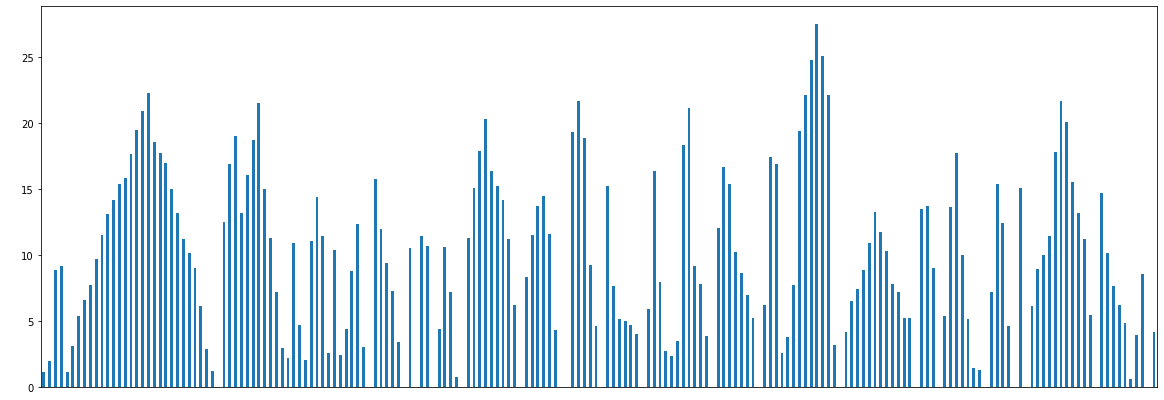

In [14]:
'''Test graph to look at the distances of the shape points in comparison to stops along the route'''
# plot the distance from the stop... the 'valleys' are where the stops are

plt.figure()
plt.ylabel("Distance From Stop").set_color("White")
subShapes['dist_to_stp'].plot(kind='bar',figsize=(20,7)).axes.get_xaxis().set_visible(False)
plt.show()

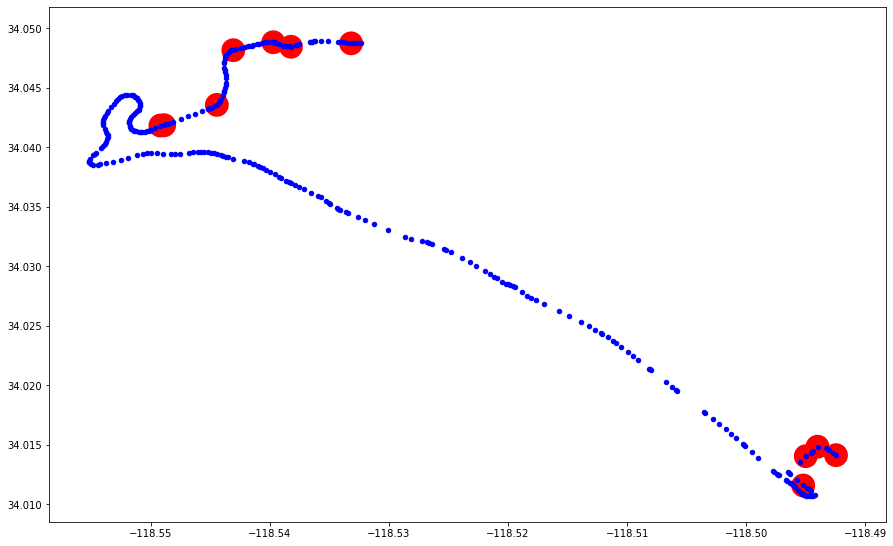

In [169]:
'''Test map (graph) to look at ALL of the shape points for a route in comparison to stops along the route'''
# plot the stops (red) and the shape points the script returns (blue)
# all of the shape points FOR TESTING

# wantedShapes = shapes[shapes.shape_id == 24242]
allShapePoints = gpd.GeoDataFrame(finalMerge, geometry=gpd.points_from_xy(finalMerge.shape_pt_lon,finalMerge.shape_pt_lat))
allStopPoints = gpd.GeoDataFrame(subStops, geometry=gpd.points_from_xy(subStops.stop_lon,subStops.stop_lat))
allStopPoints['geometry'] = stopdf.geometry.buffer(.001)
stopsTest = allStopPoints.plot(figsize=(15,15),color='red')
# allShapePoints.plot(figsize=(15,15),color='blue')
allShapePoints.plot(ax=stopsTest, color='blue',marker='o',markersize=20)
plt.show()

In [175]:
'''Test map (graph) to look at a subset of the shape points identifed as being nearest to stops along the route'''
keepOnly = finalMerge[(finalMerge.joined == 'true')]
# keepOnly = finalMerge[(finalMerge.keep == 'keep')]
testPointsdf = gpd.GeoDataFrame(keepOnly, geometry=gpd.points_from_xy(keepOnly.shape_pt_lon,keepOnly.shape_pt_lat))
stopdf = gpd.GeoDataFrame(stopdf, geometry=gpd.points_from_xy(stopdf.stop_lon,stopdf.stop_lat))
stopdf['geometry'] = stopdf.geometry.buffer(.00030)


# allShapePoints = gpd.GeoDataFrame(subShapes, geometry=gpd.points_from_xy(subShapes.shape_pt_lon,subShapes.shape_pt_lat))
#plot shape points and stops... see an extra shape point near southern part of route
stopsTest = stopdf.plot(figsize=(15,15),color='red')
testPointsdf.plot(ax=stopsTest, color='blue',marker='o')
# allShapePoints.plot(ax=stopsTest, color='blue',marker='o')

plt.show()
    

AttributeError: 'DataFrame' object has no attribute 'joined'